# South African Language Identification

### EDSA 2022 Classification Hackathon

©  Explore Data Science Academy


---

### Honour Code

I **Abubakarsadiq Ibrahim Gajimi**, confirm - by submitting this document - that the solutions in this notebook are a result of my own work and that I abide by the [EDSA honour code](https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing)


### Overview

South Africa is a multicultural society that is characterised by its rich linguistic diversity. Language is an indispensable tool that can be used to deepen democracy and also contribute to the social, cultural, intellectual, economic and political life of the South African society.

The country is multilingual with 11 official languages, each of which is guaranteed equal status. Most South Africans are multilingual and able to speak at least two or more of the official languages.

<img src="pic.jpg" alt="train/test split ordering tweet" width="600px;">

In this challenge, you will take text which is in any of South Africa's 11 Official languages and identify which language the text is in. This is an example of NLP's Language Identification, the task of determining the natural language that a piece of text is written in.


- 1. analyse the data
- 2. clean the existing data set;
- 3. determine if additional features can be added to enrich the data set;
- 4. build a model that is capable of predicting language the text is in;
- 5. evaluate the accuracy of the best machine learning model;
- 6. explain the inner working of the model to a non-technical audience.


<a id="cont"></a>

## Table of Contents

<a href=#one>1. Importing Packages</a>

<a href=#two>2. Loading Data</a>

<a href=#three>3. Exploratory Data Analysis (EDA)</a>

<a href=#four>4. Data Engineering</a>

<a href=#five>5. Modeling</a>

<a href=#six>6. Model Performance</a>


 <a id="one"></a>
## 1. Importing Packages
<a href=#cont>Back to Table of Contents</a>

In this section we will be importing the required libraries to manipulate and model the data

In [45]:
# Libraries for data loading, data manipulation and data visulisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Libraries for data cleaning and preprocessing
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import string
import re

#Libraries for data preparation and modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

# Libraries for model Evaluation
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score


 <a id="two"></a>
## 2. Loading the Data
<a href=#cont>Back to Table of Contents</a>

We will first start by loading in our data as pandas dataframe

In [46]:
#loading the training and testing data
train = pd.read_csv('train_set.csv')
test = pd.read_csv('test_set.csv')

In [47]:
#load the sample submission file
sample_submission = pd.read_csv('sample_submission.csv')

<a id="three"></a>
# 3. EDA
<a href=#cont>Back to Table Contents</a>

**Exploratory Data Analysis** (EDA), First we will start by exploring our dataset to understand the data that we are working with and to gain more insights into the dataset

In [48]:
#let's take look at the frist few row of the training dataset
train.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


looking at the above columns we can see that the data contains `two` columns `land_id` and `text`.

Based on the  above observation our **feature** is the `text` column and our **target** is the `lang_id` column 

In [49]:
#let's a look at the test dataset
test.head()

,index,text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele..."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.
3,4,Kube inja nelikati betingevakala kutsi titsini...
4,5,Winste op buitelandse valuta.


The test dataset contains `text` and `index` column 

Moving on next, let's take look at the `sample submission` file to see what we are suppose to submit after performing the modeling

In [50]:
sample_submission.head()

,index,lang_id
0,1,tsn
1,2,nbl


The sample submission file shows that we are going to submit a dataframe with two columns which are the `index` and `lang_id` column.

The **index** is the index of the text we predicted and the **lang_id** is the prediction we made on the text column of the test data

In [51]:
#let take look at the shap of the training dataframe
train.shape[0]
print("The training dataframe contains: {0} and {1} columns".format(train.shape[0], train.shape[1]))

The training dataframe contains: 33000 and 2 columns


let's check for null values in the training dataset

In [52]:
#checking for null values in the training data
train.isnull().sum()

lang_id    0
text       0
dtype: int64

Looks good we don't have any null values in the training dataset

Moving on next let's take closer on the target variable `lang_id`

In [53]:
#taking at number of unique values in lang_id
print("The target variable lang_id has {0} number unique values".format(train['lang_id'].nunique()))

The target variable lang_id has 11 number unique values


In [54]:
#let's take a look at the unique values
train['lang_id'].unique()

array(['xho', 'eng', 'nso', 'ven', 'tsn', 'nbl', 'zul', 'ssw', 'tso',
       'sot', 'afr'], dtype=object)

We will take a look at the sample distribution of target variable to gain more insight 

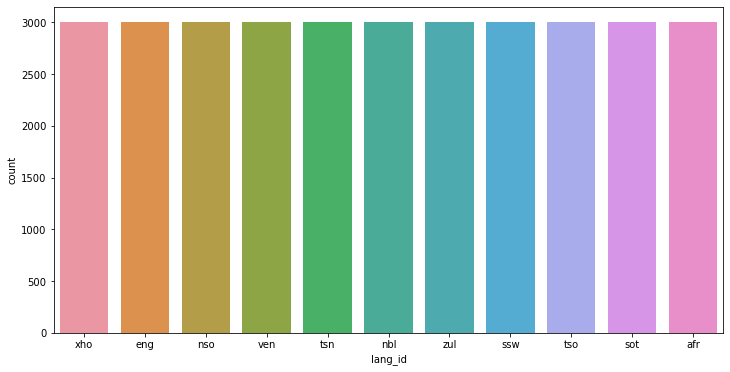

In [55]:
#using seaborn's countplot function
fig, axis = plt.subplots(figsize=(12, 6))
axis = sns.countplot(x='lang_id', data=train)
plt.show()

Will as we can see from the above plot the unique values inside the target variable are uniform, which means that our data is balance

In [56]:
#taking a look at the text column
train['text']

0        umgaqo-siseko wenza amalungiselelo kumaziko ax...
1        i-dha iya kuba nobulumko bokubeka umsebenzi na...
2        the province of kwazulu-natal department of tr...
3        o netefatša gore o ba file dilo ka moka tše le...
4        khomishini ya ndinganyiso ya mbeu yo ewa maana...
                               ...                        
32995    popo ya dipolateforomo tse ke go tlisa boetele...
32996    modise mosadi na o ntse o sa utlwe hore thaban...
32997    closing date for the submission of completed t...
32998    nawuphina umntu ofunyenwe enetyala phantsi kwa...
32999    mafapha a mang le ona a lokela ho etsa ditlale...
Name: text, Length: 33000, dtype: object

Looking at the output above the data does not look like needs additional cleaning, But if anything the `text` contains just punctuation marks

## Data Cleaning

In This Section we will try to clean the data to see if that will impove the performace of the model we are trying build

In [57]:
#Data preprocessing
#function that handles the removal punctuations from the tweets
def remove_punct(text):
    """
    the function remove_punction takes in a text as input and loops through
    the text to check if a char is not in string.punctuation then it adds the 
    the char as a string 
    
    """
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

In [58]:
#applying the remove_punct function 
train['text_m'] = train['text'].apply(lambda x: remove_punct(x))
#train.head()

After applying the function and runing the data on the model the it looks like when we applying the function we are lossing some information, the model performace better without applying the function

<a id='four'></a>
# 4. Feature Engineering
<a href=#cont>Back to Table of Contents</a>

In this Section we will be applying feature engineering to the data set before trying to model the data we first have to convert the data from `letters` to `numbers`

In [59]:
#select the feature and the target variable
X = train['text']
y = train['lang_id']

We will instantiate labelEncoder we will be using the label encoder to encode the target variable from categorical to numerical values

In [60]:
#instantiation of labelEncoder
le = LabelEncoder()

In [61]:
#transform the target variable to numbers
y = le.fit_transform(y)

Next, using the ContVectorizer we will transform the feature

In [62]:
#using countVectoerizer
vectorizer = CountVectorizer()

In [63]:
#transforming the feature variable
X_count = vectorizer.fit_transform(X)

In [64]:
#shape of the feature after applying the countvectorizer
X_count.shape

(33000, 141958)

Next up we will split our dataset into training and test data using `train_test_split`

In [65]:
# Split Data (into Training & Test)
X_train, X_test, y_train, y_test = train_test_split(X_count, y, test_size=0.25, random_state=0)

---

## Test Data

We will be applying the same thing we did on the training dataset to the test dataset here, all the steps here are thesame as above

In [66]:
test.head()

,index,text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele..."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.
3,4,Kube inja nelikati betingevakala kutsi titsini...
4,5,Winste op buitelandse valuta.


In [67]:
#test['text_m'] = test['text'].apply(lambda x: remove_punct(x))

In [68]:
#applying countVectorizer on the test dataset
x_test = vectorizer.transform(test['text'])

In [69]:
x_test.shape

(5682, 141958)

<a id='five'></a>
# 5. Modeling
<a href=#cont>Back to Table of Contents</a>

In This Section we will be modeling our dataset using multiple models to see which model performs the best

In [70]:
#modeling 
clf = RandomForestClassifier(random_state = 42)
knn = KNeighborsClassifier()
naive_bayes = MultinomialNB()

In [71]:
#fitting the model
clf.fit(X_train, y_train)
knn.fit(X_train, y_train)
naive_bayes.fit(X_train, y_train)

MultinomialNB()

In [72]:
#apply prediction to the model
y_pred = clf.predict(X_test)
y_knn = knn.predict(X_test)
y_nv = naive_bayes.predict(X_test)

<a id='six'></a>
# 6. Mode performances
<a href=#cont>Back to Table of Contents</a>

Model Evaluation In this section we will evalute the above trained models to which model has the the best performance i.e the model with the highest `F1_score` and making sure that the model is not `over` or `under fitting` the data

In [76]:
#f1_score for the knn model
f1_knn = f1_score(y_test, y_knn, average = 'weighted')
print("The f1_score of the knn model is: {}".format(f1_knn))
#f1_score for RandomForestClassifier model
f1_clf = f1_score(y_test, y_pred, average = 'weighted')
print("The f1_score of the forest model is: {}".format(f1_clf))
#f1_score for the naive model
f1_naive = f1_score(y_test, y_nv, average = 'weighted')
print("The f1_score of the naive model is: {}".format(f1_naive))

The f1_score of the knn model is: 0.9233981659859274
The f1_score of the forest model is: 0.9865861157986
The f1_score of the naive model is: 0.9992730020680997


In [82]:
performance = pd.DataFrame([f1_knn, f1_clf, f1_naive], columns=['F1_Scores'])
performance.head()

,F1_Scores
0,0.923398
1,0.986586
2,0.999273


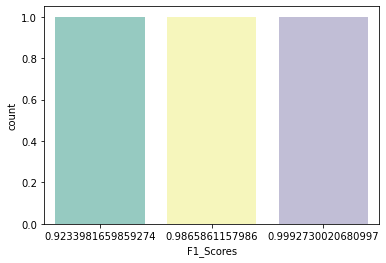

In [89]:
#using seaborn's countplot function
fig, axis = plt.subplots(figsize=(6, 4))
axis = sns.countplot(x='F1_Scores', data=performance, palette="Set3")
plt.show()

Will as you can see the model with the best performace here is `naive bayes` model it has the highest F1_score out of the other two models

### Applying the model to make prediction on an unseen data

In this Section we will apply the model on the test dataset

In [77]:
#making predictions
prediction = naive_bayes.predict(x_test)

In [78]:
#transforming the prediction from numbers to word
prediction = le.inverse_transform(prediction)
prediction

array(['tsn', 'nbl', 'ven', ..., 'sot', 'sot', 'nbl'], dtype=object)

### Creating a dataframe for the prediction 

In [79]:
submission = pd.DataFrame(list(zip(test['index'], prediction)), columns=['index', 'lang_id'])

In [80]:
submission.head()

,index,lang_id
0,1,tsn
1,2,nbl
2,3,ven
3,4,ssw
4,5,afr


Next we will save the file as csv

In [81]:
#saving the file as csv for submission
submission.to_csv('submission_v13.csv', index=False, index_label=False)